In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from skbio.diversity import beta_diversity
from skbio.stats.distance import permanova
import matplotlib.pyplot as plt

In [2]:
metadata_species_df = pd.read_csv('taxonomy_species_metadata_biomass_merged.csv', index_col = 0)
metadata_species_df['Stems'].fillna(0, inplace = True)
metadata_species_df['Shoots'].fillna(0, inplace = True)
metadata_species_df['Leaves'].fillna(0, inplace = True)
metadata_species_df['Grain 0% MC'].fillna(0, inplace = True)
metadata_species_df['Total biomass'] = metadata_species_df[['Stems', 'Shoots', 'Leaves', 'Grain 0% MC']].sum(axis = 1)

# Convert the dates from string to datetime
metadata_species_df['Sample date'] = pd.to_datetime(metadata_species_df['Sample date'])
metadata_species_df['Barcode'] = metadata_species_df['Barcode'].astype(int).astype(str)
metadata_species_df['NxWater'] = metadata_species_df['Nitrogen'] + '_' + metadata_species_df['Water']

# Find the earliest date
earliest_date = metadata_species_df['Sample date'].min()

# Calculate the number of days elapsed since the earliest date
metadata_species_df['Days Elapsed'] = (metadata_species_df['Sample date'] - earliest_date).dt.days

metadata_species_df.head()

,Sample date,Sample ID,Plot,ID,Nitrogen,Water,Block,Direction,Barcode,Notes,...,Paraglomus brasilianum,Paraglomus laccatum,Redeckera fulvum,Scutellospora nodosa,Scutellospora pellucida,Scutellospora projecturata,Scutellospora spinosissima,Total biomass,NxWater,Days Elapsed
barcode53B,2021-06-15,2N,2N,111.0,Low,High,1,N,53,NxW_B library,...,0.000000,0.00000,0.000000,0.0,0.000000,52.007834,0.0,3.56,Low_High,0
barcode65B,2021-06-15,2S,2S,111.0,Low,High,1,S,65,NxW_B library,...,0.000000,0.00000,13.179038,0.0,24.524424,45.840968,0.0,3.56,Low_High,0
barcode72B,2021-06-15,23S,23S,211.0,Low,High,2,S,72,NxW_B library,...,38.251551,43.59947,0.000000,0.0,26.747810,0.000000,0.0,2.65,Low_High,0
barcode81B,2021-06-15,23N,23N,211.0,Low,High,2,N,81,NxW_B library,...,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,2.65,Low_High,0
barcode55B,2021-06-15,32N,32N,311.0,Low,High,3,N,55,NxW_B library,...,31.590360,38.35696,19.312906,0.0,29.028538,22.754466,0.0,2.11,Low_High,0


In [25]:
# Select columns to be normalized
amf_species = ['Acaulospora sp.', 'Ambispora fennica',
       'Ambispora leptoticha', 'Archaeospora trappei',
       'Claroideoglomus lamellosum', 'Diversispora epigaea',
       'Diversispora spurca', 'Diversispora trimurales',
       'Entrophospora baltica', 'Geosiphon pyriformis',
       'Glomus Afrothismia foertheriana symbiont',
       'Glomus Arachnitis uniflora symbiont',
       'Glomus Burmannia hexaptera symbiont',
       'Glomus Voyriella parviflora symbiont type 1', 'Glomus caledonium',
       'Glomus clarum', 'Glomus coronatum', 'Glomus manihotis',
       'Glomus mosseae', 'Glomus proliferum', 'Glomus sp. 1',
       'Glomus sp. 2', 'Glomus sp. 3', 'Glomus sp. 4',
       'Pacispora scintillans', 'Paraglomus brasilianum',
       'Paraglomus laccatum', 'Redeckera fulvum', 'Scutellospora nodosa',
       'Scutellospora pellucida', 'Scutellospora projecturata',
       'Scutellospora spinosissima'
]

# Calculate the sum for each row
total_counts = metadata_species_df[amf_species].sum(axis=1)

# Divide each count by the total count and multiply by a constant (e.g., 1e6)
scaling_factor = 1e6
normalized_counts = metadata_species_df[amf_species].divide(total_counts, axis=0) * scaling_factor

# Replace the original columns with the normalized values
metadata_species_df[amf_species] = normalized_counts.fillna(0)

In [28]:
# Define the species
species_list = ['Glomus Arachnitis uniflora symbiont','Glomus proliferum',
          'Glomus sp. 3','Acaulospora sp.', 'Ambispora fennica', 'Ambispora leptoticha', 'Archaeospora trappei', 'Claroideoglomus lamellosum',
           'Diversispora epigaea', 'Diversispora spurca', 'Diversispora trimurales', 'Entrophospora baltica',
           'Geosiphon pyriformis', 'Glomus Afrothismia foertheriana symbiont', 'Glomus Burmannia hexaptera symbiont', 
        'Glomus Voyriella parviflora symbiont type 1', 'Glomus caledonium',
           'Glomus clarum', 'Glomus coronatum', 'Glomus manihotis', 'Glomus mosseae', 'Glomus sp. 1', 'Glomus sp. 2', 
        'Glomus sp. 4', 'Pacispora scintillans',
           'Paraglomus brasilianum', 'Paraglomus laccatum', 'Redeckera fulvum', 'Scutellospora nodosa',
           'Scutellospora pellucida', 'Scutellospora projecturata', 'Scutellospora spinosissima']

# Get sample dates
sample_dates = metadata_species_df['Sample date'].unique()

# Initialize results dataframe
results_df = pd.DataFrame(index=sample_dates)

# Loop through nitrogen and water
for column in ['Nitrogen', 'Water', 'NxWater']:

    # Run PERMANOVA
    permanova_results = []
    for date in sample_dates:
        barcodes = metadata_species_df[metadata_species_df['Sample date'] == date].index
        subset_df2 = metadata_species_df[metadata_species_df.index.isin(barcodes)]
        # Calculate Bray Curtis distances
        dist_matrix = beta_diversity("braycurtis", subset_df2[species_list], subset_df2.index)
        
        perm_res = permanova(dist_matrix, subset_df2[column])
        permanova_results.append((date, perm_res['test statistic'], perm_res['p-value']))
        
    # Add results to dataframe
    results_df[column] = [res[1:] for res in permanova_results]

In [31]:
results_df

,Nitrogen,Water,NxWater
2021-06-15,"(1.6200720465661649, 0.078)","(0.7988169144085635, 0.571)","(1.0948379205918075, 0.313)"
2021-06-30,"(2.907265678708118, 0.004)","(1.1555225614591271, 0.301)","(1.6131075043112875, 0.038)"
2021-07-27,"(2.18409395886414, 0.014)","(1.7945996790652483, 0.068)","(1.8357278271097794, 0.004)"
2021-08-10,"(1.3581157827634767, 0.165)","(0.9944069555017475, 0.423)","(1.2875463381448324, 0.146)"
2021-09-23,"(1.7239405271610106, 0.052)","(1.3571132682879719, 0.217)","(1.4457990135807957, 0.059)"


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error 

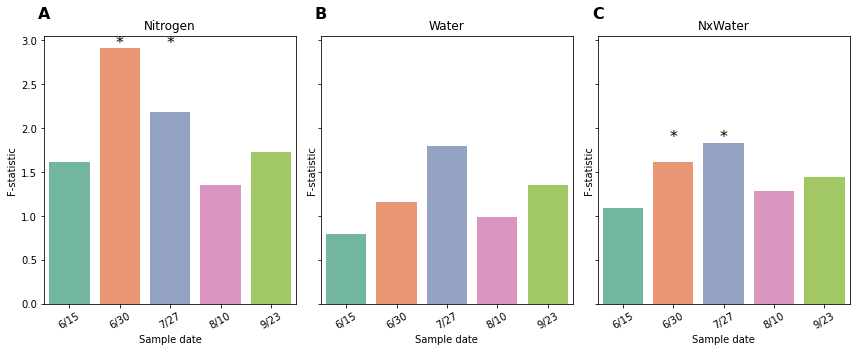

In [33]:
# Melt results dataframe
results_df.index.name = 'Sample date'
melted_df = results_df.reset_index().melt(id_vars='Sample date',
                                          var_name='Treatment', 
                                          value_name='Value')

# Extract F-stat and p-value
melted_df['F_stat'] = melted_df['Value'].apply(lambda x: x[0]) 
melted_df['p_value'] = melted_df['Value'].apply(lambda x: x[1])

# Extract month and day 
melted_df['Month'] = melted_df['Sample date'].dt.month
melted_df['Day'] = melted_df['Sample date'].dt.day

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

for i, metric in enumerate(melted_df['Treatment'].unique()):
    subset = melted_df[melted_df['Treatment'] == metric]
    ax = axs[i]
    sns.barplot(subset['Sample date'], subset['F_stat'], ax=axs[i], palette='Set2')
    ax.set_title(metric)
    ax.set_ylabel('F-statistic')
    ax.set_xticklabels([f'{m}/{d}' for m, d in zip(subset['Month'], subset['Day'])],
                       rotation=30)
    x_pos = ax.get_xticks()
    for j, p in enumerate(subset['p_value']):
        if p < 0.05:
            ax.text(x_pos[j], max(subset['F_stat'])+0.01, '*', fontsize=16, ha='center')
    
    # Adding labels A, B, C above the subplots
    ax.text(0, 1.08, chr(65 + i), transform=ax.transAxes, fontsize=16, va='center', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../../Fungal manuscript/Figures/AMF_permanovas_f-stat.jpg', bbox_inches='tight', dpi=300)

In [ ]:
# As plants are growing, have nitrate over time. Look at treatment differences for NO3 and NH4, by date

In [8]:
melted_df[['Sample date','Treatment', 'F_stat', 'p_value']]

,Sample date,Treatment,F_stat,p_value
0,2021-06-15,Nitrogen,1.311172,0.146
1,2021-06-30,Nitrogen,2.013183,0.015
2,2021-07-27,Nitrogen,1.700666,0.025
3,2021-08-10,Nitrogen,1.165228,0.282
4,2021-09-23,Nitrogen,1.696705,0.041
5,2021-06-15,Water,0.826278,0.593
6,2021-06-30,Water,1.802228,0.083
7,2021-07-27,Water,1.843225,0.044
8,2021-08-10,Water,1.054772,0.386
9,2021-09-23,Water,1.501909,0.146


In [1]:
import skbio
print(skbio.__version__)

0.5.6
